# Rozpoznávání číslic pomocí neuronových sítí

!pip install -r requirements.txt

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [57]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [58]:
#device = 'cpu'  # Force CPU for this example

In [59]:
torch.device(device)

device(type='cuda')

## Příprava dat

In [60]:
from torchvision.datasets import MNIST

dataset = MNIST(root = 'data/', download = True)
print(len(dataset))

60000


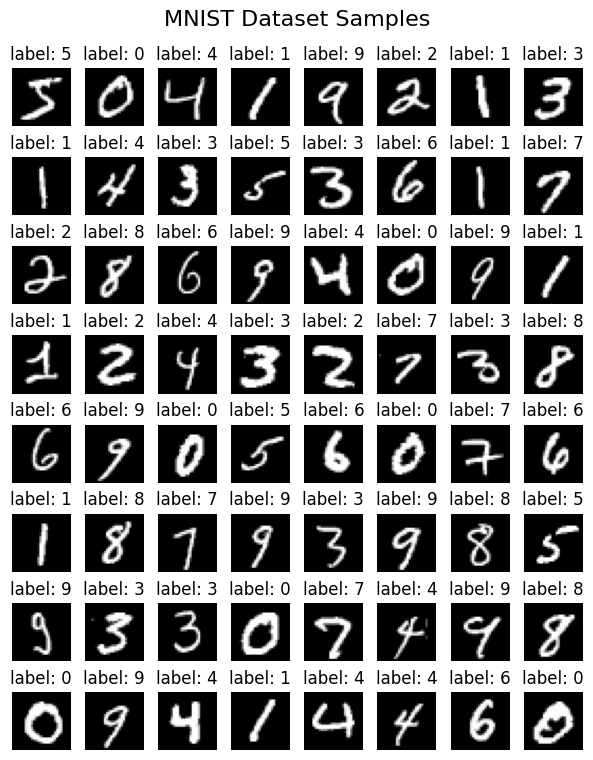

In [61]:
N = 64
plt.figure(figsize=(6, 8))
for i in range(N):
    a = int(np.sqrt(N))
    plt.subplot(a, a, i + 1)
    image, label = dataset[i]
    #image = np.array(image)
    #image = image.reshape((28, 28))
    plt.axis('off')
    plt.imshow(image, cmap = 'gray')
    plt.title(f'label: {label}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('MNIST Dataset Samples', fontsize=16)
plt.show()

In [62]:
test_fraction = 0.2

Ntrain = int(len(dataset) * (1 - test_fraction))
print(f'Train size: {Ntrain}, Test size: {len(dataset) - Ntrain}')

X_train, y_train = dataset.data[:Ntrain], dataset.targets[:Ntrain]
X_test, y_test = dataset.data[Ntrain:], dataset.targets[Ntrain:]

Train size: 48000, Test size: 12000


In [63]:
# Scale images to the [0, 1] range
X_train = X_train.float() / 255
X_test = X_test.float() / 255

X_train = X_train.unsqueeze(1)  # Add channel dimension
X_test = X_test.unsqueeze(1)    # Add channel dimension

def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return torch.eye(num_classes)[y].float()

num_classes = 10

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [64]:
X_train.shape

torch.Size([48000, 1, 28, 28])

In [65]:
y_train[0], y_train.shape

(tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), torch.Size([48000, 10]))

## Konstrukce modelu

### MLP model

In [66]:
import torch.nn as nn
import torch.optim as optim

input_size = (1, 28, 28)  # (channels, height, width)

hidden_size = 64  # Example hidden layer size

num_classes = 10

# Define the CNN model
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(input_size[-1]**2, hidden_size),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(hidden_size, 20),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(20, num_classes),
    nn.ReLU(),
    #nn.Softmax(dim=0)  # Softmax for multi-class classification
).to(device)
print(model)

# loss function and optimizer
loss_fn = nn.CrossEntropyLoss().to(device)  # cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=64, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=64, out_features=20, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): Linear(in_features=20, out_features=10, bias=True)
  (8): ReLU()
)


### CNN model

In [67]:
import torch.nn as nn
import torch.optim as optim

input_size = (1, 28, 28)  # (channels, height, width)

kernel_size = 5
padding = kernel_size // 2  # Padding to keep the output size same as input size

channels_1 = 64
channels_2 = 128

kernel_size_pool = 3
stride_pool = 3

num_classes = 10

# Define the CNN model
model = nn.Sequential(
    nn.Conv2d(kernel_size=kernel_size, in_channels=1, out_channels=channels_1, padding=padding),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=kernel_size_pool, stride=stride_pool),
    nn.Dropout(0.4),
    nn.Conv2d(kernel_size=kernel_size, in_channels=channels_1, out_channels=channels_2, padding=padding),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=kernel_size_pool, stride=stride_pool),
    nn.Flatten(),  # Flatten the output for the fully connected layer
    nn.Dropout(0.4),
    nn.Linear((input_size[-1]//stride_pool**2)**2*channels_2, num_classes),
    #nn.ReLU(),
    #nn.Linear(40, 10),
    #nn.Softmax(dim=0)  # Softmax for multi-class classification
).to(device)
print(model)

# loss function and optimizer
loss_fn = nn.CrossEntropyLoss().to(device)  # cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.4, inplace=False)
  (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Dropout(p=0.4, inplace=False)
  (9): Linear(in_features=1152, out_features=10, bias=True)
)


In [68]:
from torchsummary import summary

summary(model, input_size=input_size, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           1,664
              ReLU-2           [-1, 64, 28, 28]               0
         MaxPool2d-3             [-1, 64, 9, 9]               0
           Dropout-4             [-1, 64, 9, 9]               0
            Conv2d-5            [-1, 128, 9, 9]         204,928
              ReLU-6            [-1, 128, 9, 9]               0
         MaxPool2d-7            [-1, 128, 3, 3]               0
           Flatten-8                 [-1, 1152]               0
           Dropout-9                 [-1, 1152]               0
           Linear-10                   [-1, 10]          11,530
Total params: 218,122
Trainable params: 218,122
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.03
Params size (MB): 0.83
Estimated T

## Trénování neuronové sítě

In [69]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    y_true = torch.argmax(y_true, dim=1)  # Convert one-hot encoded labels to class indices
    y_pred = torch.argmax(y_pred, dim=1)  # Convert model outputs to class indices
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [70]:
n_epochs = 20    # number of epochs to run
batch_size = 256  # size of each batch
batches_per_epoch = len(X_train) // batch_size

loss_array = []  # to store loss values
acc_array = []  # to store accuracy values
test_acc_array = []  # to store test accuracy values

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(n_epochs):
    ### Training
    model.train()
    
    for i in range(batches_per_epoch):    
        start = i * batch_size
        # take a batch
        Xbatch = X_train[start:start+batch_size]
        ybatch = y_train[start:start+batch_size]
        # forward pass
        y_pred = model(Xbatch)
        #print(y_pred.shape, y_pred[0,:])
        loss = loss_fn(y_pred, ybatch)
        acc = accuracy_fn(ybatch, y_pred) 
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        
        loss_array.append(loss.item())
        acc_array.append(acc)
        
        print(f'Epoch {epoch + 1}/{n_epochs}, Batch {i + 1}/{batches_per_epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}%', end='\r')    
        
    ### Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        y_pred = model(X_test).squeeze() 
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(y_pred, y_test)
        test_acc = accuracy_fn(y_test, y_pred)
        
        test_acc_array.append(test_acc)

        # Print out what's happening every epoch
        print(f"Epoch: {epoch + 1} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
        

Epoch: 1 | Loss: 0.07993, Accuracy: 97.66% | Test loss: 0.09396, Test acc: 97.23%
Epoch: 2 | Loss: 0.07103, Accuracy: 98.44% | Test loss: 0.06375, Test acc: 98.12%
Epoch: 3 | Loss: 0.04562, Accuracy: 98.83% | Test loss: 0.05066, Test acc: 98.53%
Epoch: 4 | Loss: 0.04394, Accuracy: 98.83% | Test loss: 0.04229, Test acc: 98.77%
Epoch: 5 | Loss: 0.04113, Accuracy: 98.44% | Test loss: 0.03849, Test acc: 98.82%
Epoch: 6 | Loss: 0.02669, Accuracy: 98.83% | Test loss: 0.03443, Test acc: 98.91%
Epoch: 7 | Loss: 0.01614, Accuracy: 99.61% | Test loss: 0.03527, Test acc: 98.95%
Epoch: 8 | Loss: 0.02269, Accuracy: 99.22% | Test loss: 0.03326, Test acc: 98.98%
Epoch: 9 | Loss: 0.02267, Accuracy: 99.22% | Test loss: 0.03090, Test acc: 99.08%
Epoch: 10 | Loss: 0.01244, Accuracy: 99.61% | Test loss: 0.02870, Test acc: 99.07%
Epoch: 11 | Loss: 0.02294, Accuracy: 99.22% | Test loss: 0.03254, Test acc: 99.01%
Epoch: 12 | Loss: 0.02505, Accuracy: 98.83% | Test loss: 0.03078, Test acc: 99.09%
Epoch: 13 | L

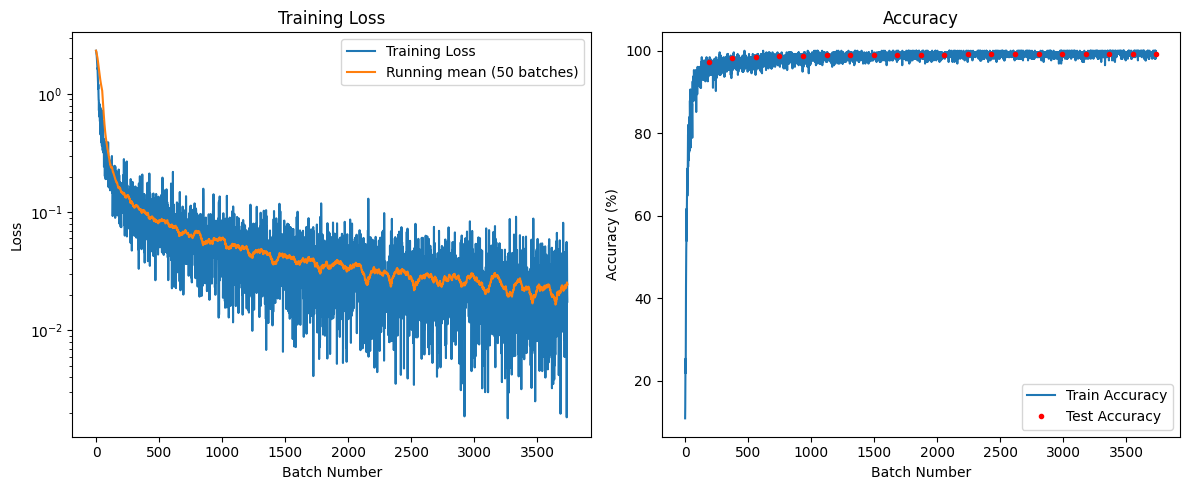

In [71]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    r_avg = (cumsum[N:] - cumsum[:-N]) / float(N)
    res = np.zeros(len(x))
    res[N-1:] = r_avg
    for i in range(N-1):
        res[i] = (cumsum[i+1]) / float(i+1)
    return res

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_array, label='Training Loss')
N_avg = 50  # Number of batches to average over
plt.plot(running_mean(loss_array, N_avg), '-', label=f'Running mean ({N_avg} batches)')
plt.title('Training Loss')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(acc_array, label='Train Accuracy')
plt.plot((np.arange(n_epochs)+1)*batches_per_epoch, test_acc_array, '.r', label='Test Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy (%)')
plt.tight_layout()

## Ohodnocení modelu

In [72]:
# Make predictions
model.eval()
with torch.inference_mode():
    y_preds = model(X_test)  # Apply softmax to get probabilities

In [73]:
y_pred_nums = np.argmax(y_preds.cpu(), axis=1)
correct = np.sum((y_pred_nums == np.argmax(y_test.cpu(), axis=1)).numpy())  # compare with true labels
print(f'Accuracy: {correct / len(y_test) * 100:.2f}%')

Accuracy: 99.20%


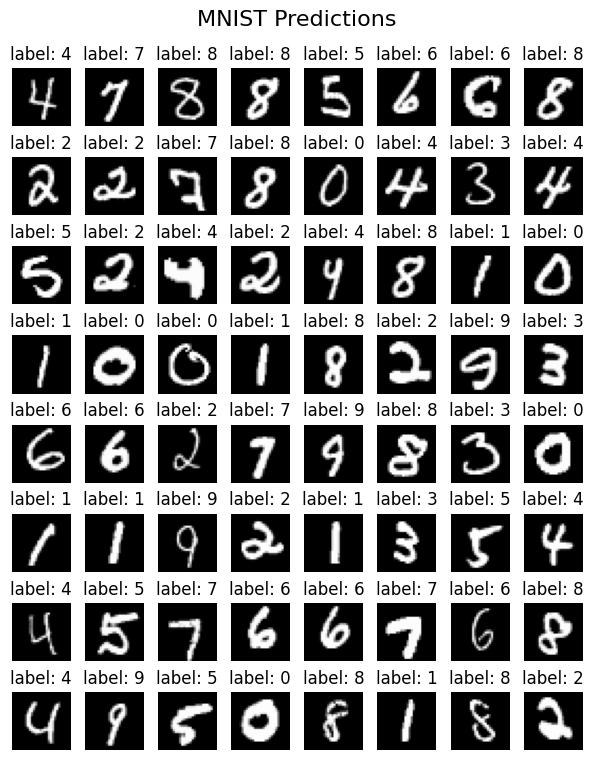

In [74]:
N = 64
plt.figure(figsize=(6, 8))
for i in range(N):
    a = int(np.sqrt(N))
    plt.subplot(a, a, i + 1)
    image = X_test[i].cpu().squeeze().numpy()  # Remove channel dimension
    label = np.argmax(y_preds[i].cpu().detach().numpy())
    plt.axis('off')
    plt.imshow(image, cmap = 'gray')
    plt.title(f'label: {label}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('MNIST Predictions', fontsize=16)
plt.show()

In [75]:
import datetime

dt = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
print(dt)

torch.save(model.state_dict(), f'model_mnist_cnn_{dt}.pth')

20250621205605


In [76]:
model.load_state_dict(torch.load('model_mnist_cnn_20250621162737.pth'))

<All keys matched successfully>

## Vizualizace

In [77]:
from torchviz import make_dot
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

y_pred = model(X_train[0:1])  # Get predictions for the first training sample

make_dot(y_pred, params=dict(list(model.named_parameters()))).render("cnn_torchviz", format="png")

'cnn_torchviz.png'

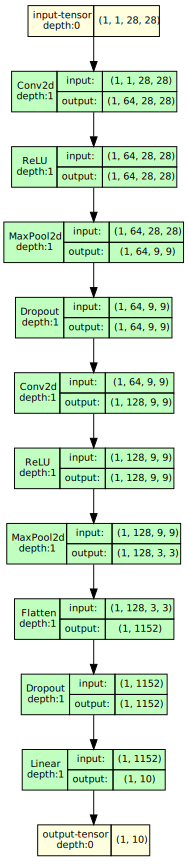

In [78]:
import torchvision
from torchview import draw_graph

model_graph = draw_graph(model, input_size=(1,1,28,28), expand_nested=True)
model_graph.visual_graph

### Váhy konvolučních vrstev

In [79]:
weight_list = []

for m in model.modules():
    if isinstance(m, nn.Conv2d):
        print(m.weight.shape)
        weight_list.append(m.weight)

torch.Size([64, 1, 5, 5])
torch.Size([128, 64, 5, 5])


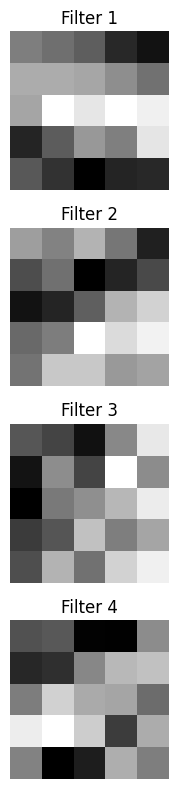

In [80]:
cnv1_weights = weight_list[0]
plt.figure(figsize=(8, 8))
filter_count = np.minimum(cnv1_weights.shape[0], 4)
for i in range(filter_count):
    plt.subplot(filter_count, 1, i + 1)
    plt.imshow(cnv1_weights[i].cpu().squeeze().detach().numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f'Filter {i + 1}')
plt.tight_layout()

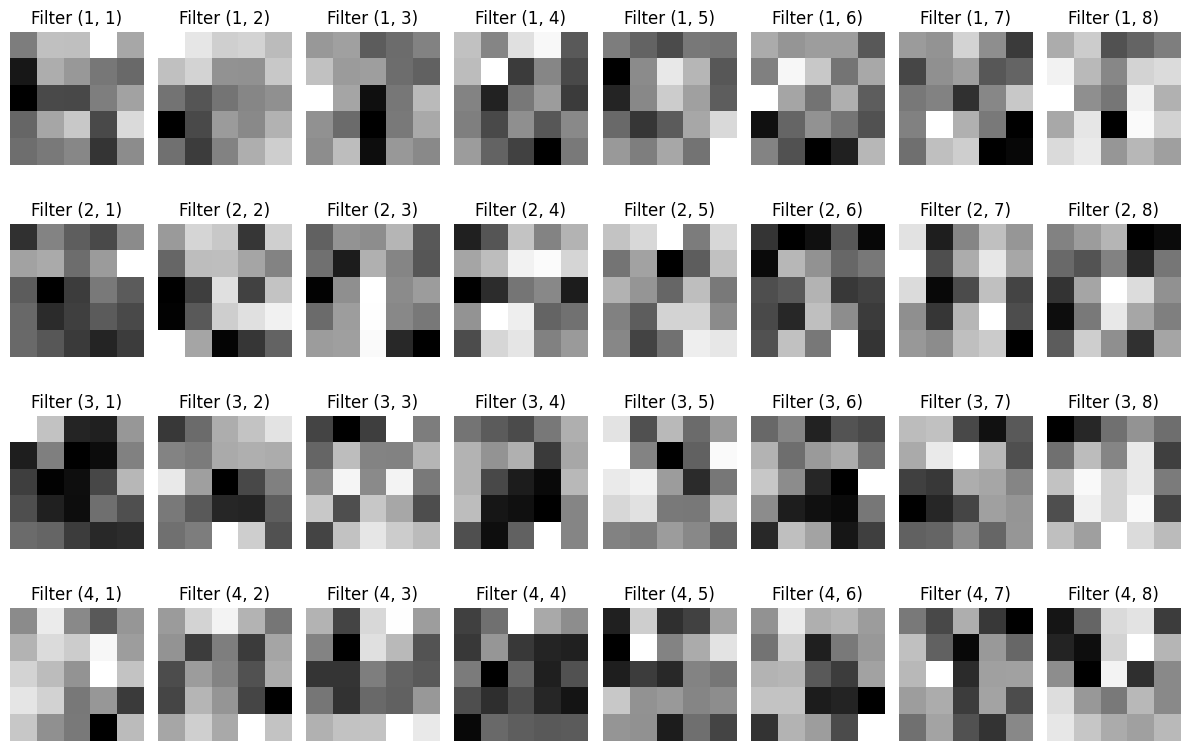

In [81]:
cnv2_weights = weight_list[1]
plt.figure(figsize=(12, 8))
filter_count1 = np.minimum(cnv2_weights.shape[0], 4)
filter_count2 = np.minimum(cnv2_weights.shape[1], 8)
for i in range(filter_count1):
    for j in range(filter_count2):
        plt.subplot(filter_count1, filter_count2, i*filter_count2 + j + 1)
        plt.imshow(cnv2_weights[i,j].cpu().squeeze().detach().numpy(), cmap='gray')
        plt.axis('off')
        plt.title(f'Filter ({i + 1}, {j + 1})')
plt.tight_layout()

### Aktivační hodnoty v neuronech

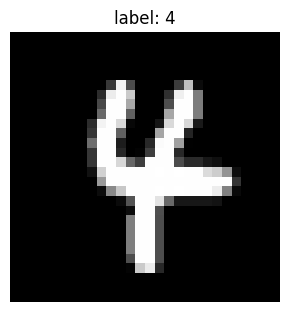

In [82]:
idx = 47 #58

plt.figure(figsize=(3, 4))
image = X_test[idx].cpu().squeeze().numpy()  # Remove channel dimension
label = np.argmax(y_preds[idx].cpu().detach().numpy())
plt.axis('off')
plt.imshow(image, cmap = 'gray')
plt.title(f'label: {label}')
#plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.tight_layout()
#plt.suptitle('MNIST Predictions', fontsize=16)
plt.show()

In [83]:
conv2d_layers = [m for m in model.modules() if isinstance(m, nn.Conv2d)]

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

conv2d_layers[0].register_forward_hook(get_activation('cnv1'))
conv2d_layers[1].register_forward_hook(get_activation('cnv2'))

y_pred = model(X_test[idx:idx+1].to(device))
num_pred = torch.argmax(y_pred, dim=1).detach().cpu().numpy().item()
print(f'Predicted label: {num_pred}, True label: {y_test[idx].argmax().item()}')

print(activation['cnv1'].shape)
print(activation['cnv2'].shape)

Predicted label: 4, True label: 4
torch.Size([1, 64, 28, 28])
torch.Size([1, 128, 9, 9])


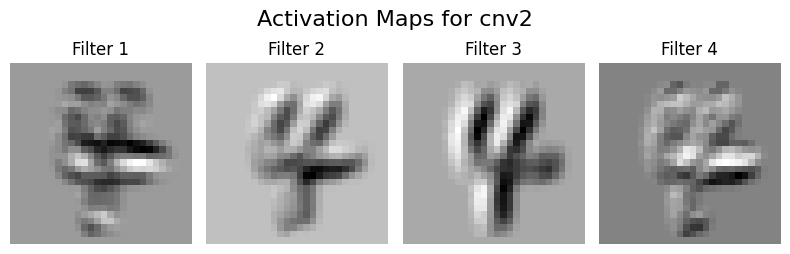

In [84]:
plt.figure(figsize=(8, 3))
filter_count = np.minimum(activation['cnv1'].shape[1], 4)
for i in range(filter_count):
    plt.subplot(1, filter_count, i + 1)
    plt.imshow(activation['cnv1'][0, i].cpu().squeeze().numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f'Filter {i + 1}')
plt.tight_layout()
plt.suptitle('Activation Maps for cnv2', fontsize=16);

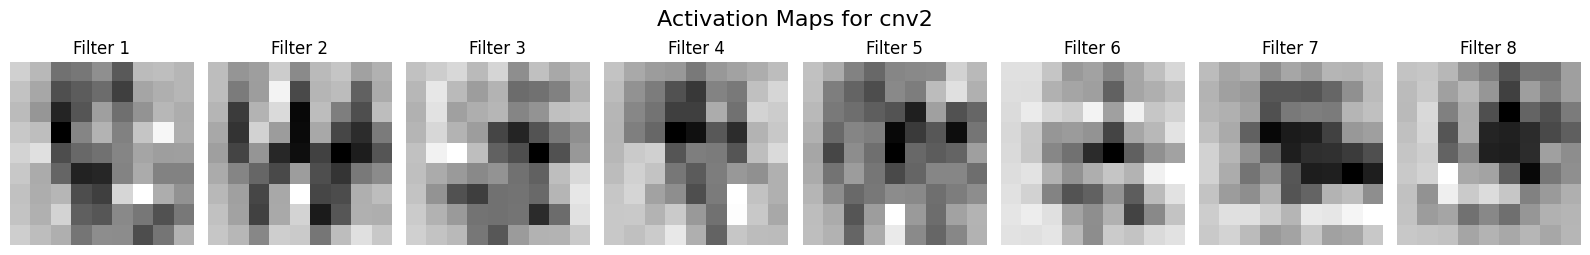

In [85]:
plt.figure(figsize=(16, 3))
filter_count = np.minimum(activation['cnv2'].shape[1], 8)
for i in range(filter_count):
    plt.subplot(1, filter_count, i + 1)
    plt.imshow(activation['cnv2'][0, i].cpu().squeeze().numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f'Filter {i + 1}')
plt.tight_layout()
plt.suptitle('Activation Maps for cnv2', fontsize=16);

### 

### Analýza aktivací pro jednotlivé číslice

In [86]:
activation['cnv1'].cpu().numpy().shape[1:]  # Get the shape of the activation map for cnv1

(64, 28, 28)

In [87]:
activ_cnv1_stats = np.zeros((*activation['cnv1'].cpu().numpy().shape[1:], 10))  # (filters_shape, num_classes)
activ_cnv2_stats = np.zeros((*activation['cnv2'].cpu().numpy().shape[1:], 10))  # (filters_shape, num_classes)

for i in range(X_test.shape[0]):
    y_pred = model(X_test[i:i+1].to(device))
    num_pred = torch.argmax(y_pred, dim=1).detach().cpu().numpy().item()
    if num_pred == y_test[i].argmax().item():
        # Add to statistics
        activ_cnv1_stats[:,:,:,num_pred] += activation['cnv1'].cpu().numpy().squeeze()
        activ_cnv2_stats[:,:,:,num_pred] += activation['cnv2'].cpu().numpy().squeeze()
        
for i in range(num_classes):
    activ_cnv1_stats[:,:,:,i] /= np.sum(y_test.cpu().numpy()[:, i])  # Normalize by the number of samples for each class
    activ_cnv2_stats[:,:,:,i] /= np.sum(y_test.cpu().numpy()[:, i])  # Normalize by the number of samples for each class

In [88]:
activ_cnv1_stats.shape

(64, 28, 28, 10)

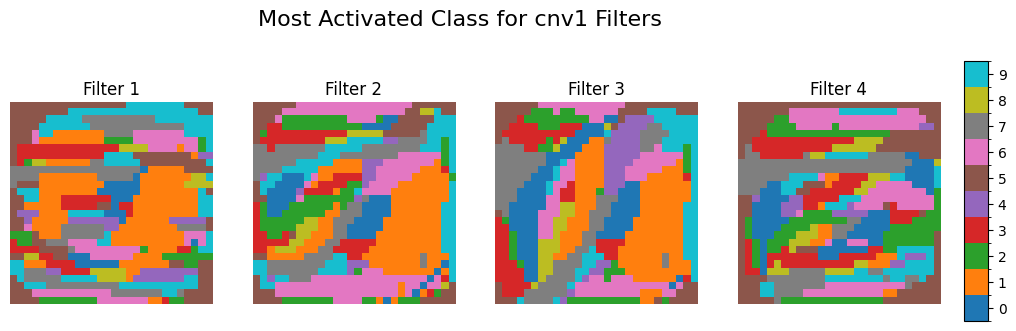

In [89]:
activ_cnv1_num = np.argmax(activ_cnv1_stats, axis=-1)  # Get the index of the maximum value along the last axis (num_classes)
#print(activ_cnv1_num[1, :, :])

import matplotlib

cmap = plt.get_cmap('tab10', 10)  # Use a colormap with 10 distinct colors

# define the bins and normalize
bounds = np.arange(0, 11)-0.5
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(12, 4))
filter_count = np.minimum(activ_cnv1_num.shape[0], 4)
for i in range(filter_count):
    plt.subplot(1, filter_count, i + 1)
    im = plt.imshow(activ_cnv1_num[i], cmap=cmap, norm=norm)
    plt.axis('off')
    plt.title(f'Filter {i + 1}')
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.65])
fig.colorbar(im, cax=cbar_ax, ticks=np.arange(11))
plt.suptitle('Most Activated Class for cnv1 Filters', fontsize=16)
#plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])
plt.show()

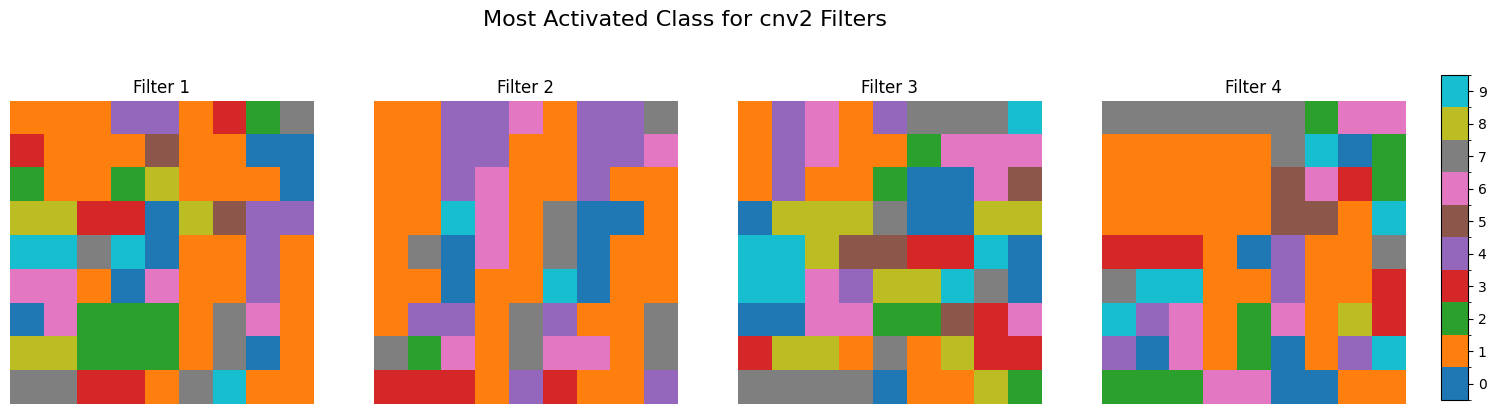

In [90]:
activ_cnv2_num = np.argmax(activ_cnv2_stats, axis=-1)  # Get the index of the maximum value along the last axis (num_classes)

fig = plt.figure(figsize=(18, 5))
filter_count = np.minimum(activ_cnv2_num.shape[0], 4)
for i in range(filter_count):
    plt.subplot(1, filter_count, i + 1)
    im = plt.imshow(activ_cnv2_num[i], cmap=cmap, norm=norm)
    plt.axis('off')
    plt.title(f'Filter {i + 1}')
cbar_ax = fig.add_axes([0.92, 0.2, 0.015, 0.65])
fig.colorbar(im, cax=cbar_ax, ticks=np.arange(11))
plt.suptitle('Most Activated Class for cnv2 Filters', fontsize=16)
#plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])
plt.show()

### Chybné klasifikace

In [91]:
y_test.shape

torch.Size([12000, 10])

In [92]:
def draw_output(idx_nums):
    plt.figure(figsize = (20, 20))
    plt.xticks( range(10) )
    x = np.ceil(np.sqrt(len(idx_nums)))
    cnt = 1
    for ph in idx_nums:
        plt.subplot(x, x, cnt)
        curr_photo = y_test[ph]
        
        plt.xlim(0, 10)
        plt.title("Digit: {0}\n idx: {1} ".format(np.argmax(y_test[ph]), ph), fontsize = 10) 
        plt.bar(range(10), y_pred[ph])
        
        cnt += 1

83 samples are misclassified


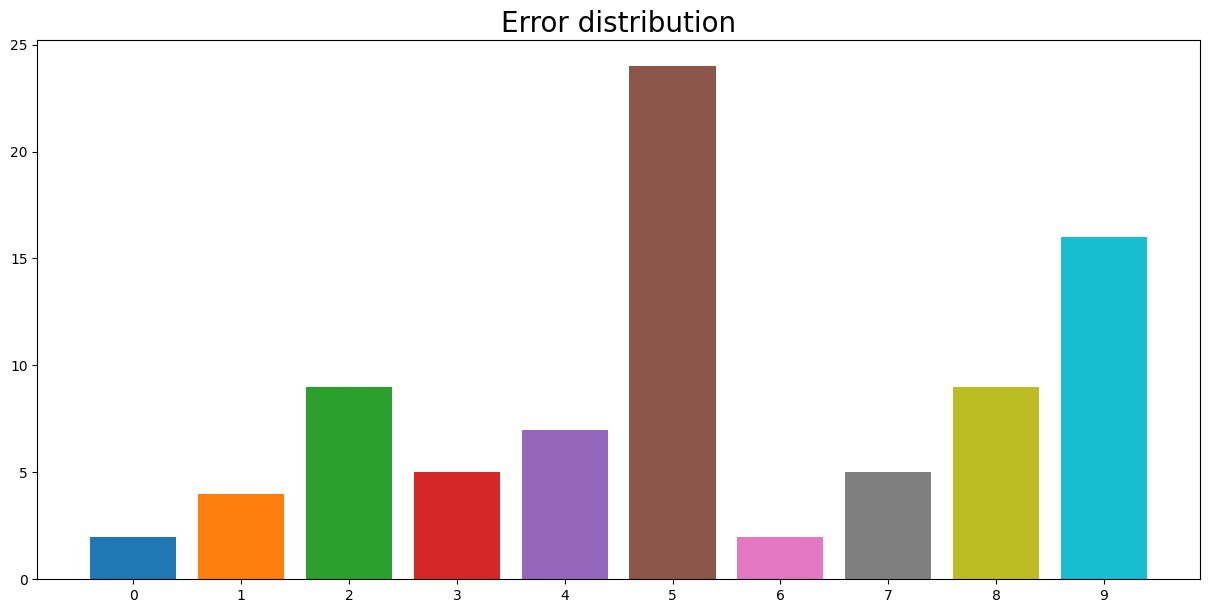

In [108]:
y_test_cpu = y_test.cpu().detach().numpy()
y_pred = model(X_test.to(device))
y_pred_cpu = y_pred.cpu().detach().numpy()

idx_noteq = np.argmax(y_test_cpu, axis=1) != np.argmax(y_pred_cpu, axis=1)
print(idx_noteq.sum(), "samples are misclassified")

cnt_error = np.argmax(y_test_cpu[idx_noteq], axis=1)
cnt_error = np.unique(cnt_error, return_counts = True)

plt.figure(figsize = (15, 7))
plt.title("Error distribution", fontsize=20)
plt.bar(cnt_error[0], cnt_error[1], color=plt.get_cmap('tab10').colors)
plt.xticks(np.arange(10))
plt.show()

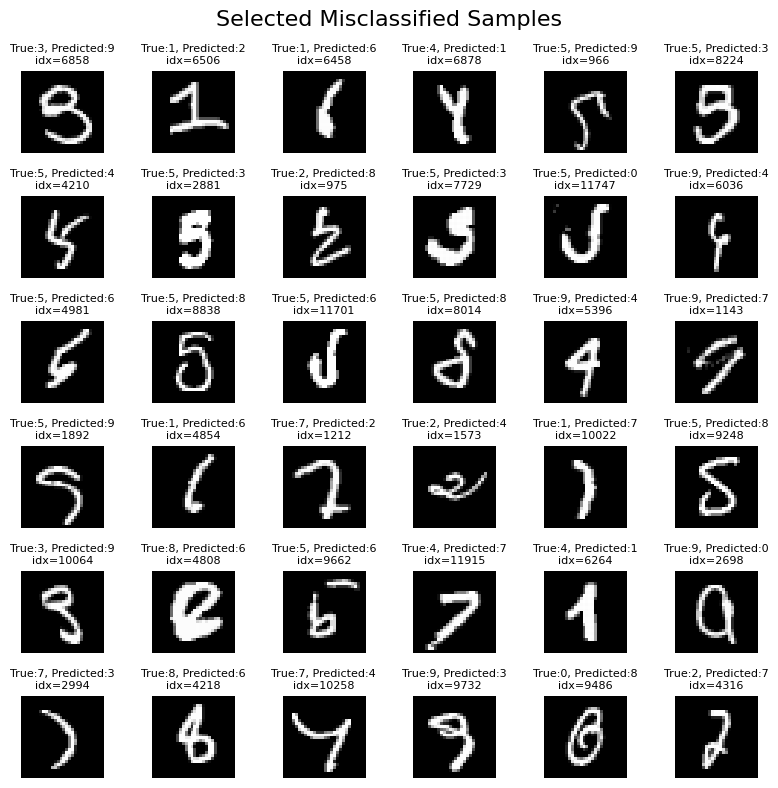

In [123]:
cnt_ind = 1
list_idx = []
fig = plt.figure(figsize=(8, 8))

# Find indices of misclassified samples
misclassified_indices = np.where(np.argmax(y_test_cpu, axis=1) != np.argmax(y_pred_cpu, axis=1))[0]

# Randomly select 64 misclassified indices (or fewer if not enough)
num_to_plot = np.minimum(36, len(misclassified_indices))
#np.random.seed(42)
selected_indices = np.random.choice(misclassified_indices, size=num_to_plot, replace=False)

for i, idx in enumerate(selected_indices, 1):
    plt.subplot(6, 6, i)
    plt.imshow(X_test[idx, 0, :, :].cpu().numpy(), cmap='gray', interpolation='none')
    true_label = np.argmax(y_test_cpu[idx])
    pred_label = np.argmax(y_pred_cpu[idx])
    plt.title(f'True:{true_label}, Predicted:{pred_label}\nidx={idx}', fontsize=8)
    plt.axis('off')
plt.suptitle('Selected Misclassified Samples', fontsize=16)
plt.tight_layout()

## Zdroje

https://www.kaggle.com/code/jedrzejdudzicz/mnist-dataset-100-accuracy